In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from keras_preprocessing.image import ImageDataGenerator
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.api.models import Model
from keras.api.optimizers import Adam
from PIL import ImageFile
from keras.api.applications import VGG16

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define new dataset path
train_dir = r"D:\sdp\redd\train"
test_dir = r"D:\sdp\redd\test"
#train_dir = r"/workspace/sdp/redd/train"
#test_dir = r"/workspace/sdp/redd/test"

In [3]:

import cv2
import random


def apply_random_degradation(image):
    degrade_options = [
        add_gaussian_blur,
        add_gaussian_noise,
        add_haze_effect,
        adjust_contrast_randomly,
        add_jpeg_artifacts
    ]

    num_degradations = random.randint(1, 2)
    selected = random.sample(degrade_options, num_degradations)

    for degrade in selected:
        image = degrade(image)

    return image


def add_gaussian_blur(image):
    """Mild Gaussian blur"""
    if random.random() < 0.3:
        kernel_size = random.choice([3, 5])
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return image


def add_gaussian_noise(image):
    """Mild Gaussian noise"""
    if random.random() < 0.3:
        row, col, ch = image.shape
        sigma = 0.01  # previously variable, now fixed low
        gauss = np.random.normal(0, sigma, (row, col, ch))
        noisy = image + gauss
        return np.clip(noisy, 0, 1)
    return image


def add_haze_effect(image):
    """Light haze"""
    if random.random() < 0.2:
        haze_factor = random.uniform(0.85, 0.95)  # previously 0.3–0.7
        haze_color = np.ones_like(image) * 0.9
        hazy = image * haze_factor + haze_color * (1 - haze_factor)
        return np.clip(hazy, 0, 1)
    return image


def adjust_contrast_randomly(image):
    """Subtle contrast adjustment"""
    if random.random() < 0.3:
        alpha = random.uniform(0.85, 1.15)
        return np.clip(alpha * image, 0, 1)
    return image


def add_jpeg_artifacts(image):
    """Mild JPEG compression artifacts"""
    if random.random() < 0.2:
        quality = random.randint(50, 80)  # narrowed quality range
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        result, encimg = cv2.imencode('.jpg', (image * 255).astype(np.uint8), encode_param)
        decimg = cv2.imdecode(encimg, 1)
        return decimg.astype(np.float32) / 255.0
    return image


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,  # Random rotation up to 40 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    brightness_range=[0.5, 1.5],  # Random brightness adjustment
    fill_mode='nearest',  # How to fill points outside boundaries
    channel_shift_range=50.0,  # Random channel shifts (color changes)
    preprocessing_function=lambda x: apply_random_degradation(x)
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [5]:
def create_vgg_transfer_model(input_shape=(150, 150, 3), num_classes=3):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='swish')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='swish')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    return model


model = create_vgg_transfer_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,89

 Total params: 14,881,347 (56.77 MB)

 Trainable params: 165,635 (647.01 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [6]:
import pickle
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

epochs = 50
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

model.save("third_model_da.h5")
with open("history3_da.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("Model and training history saved successfully!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1744090303.386233    2839 service.cc:148] XLA service 0x7f266c0125c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744090303.386276    2839 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
I0000 00:00:1744090303.673621    2839 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/469 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.2656 - loss: 1.4039  

I0000 00:00:1744090310.124431    2839 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 188s 384ms/step - accuracy: 0.4626 - loss: 1.1080 - val_accuracy: 0.8553 - val_loss: 0.4246 - learning_rate: 1.0000e-04
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 172s 366ms/step - accuracy: 0.6307 - loss: 0.7547 - val_accuracy: 0.8780 - val_loss: 0.3142 - learning_rate: 1.0000e-04
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 178s 380ms/step - accuracy: 0.6515 - loss: 0.7013 - val_accuracy: 0.8960 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 373ms/step - accuracy: 0.6595 - loss: 0.6701 - val_accuracy: 0.9023 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 373ms/step - accuracy: 0.6645 - loss: 0.6576 - val_accuracy: 0.9060 - val_loss: 0.2346 - learning_rate: 1.0000e-04
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 178s 379ms/step - accuracy: 0.6811 - loss: 0.6447 - val_accuracy: 0.9113 - val_loss: 0.2239 - learning_rate: 1.0000e-04
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 372ms/

Model and training history saved successfully!


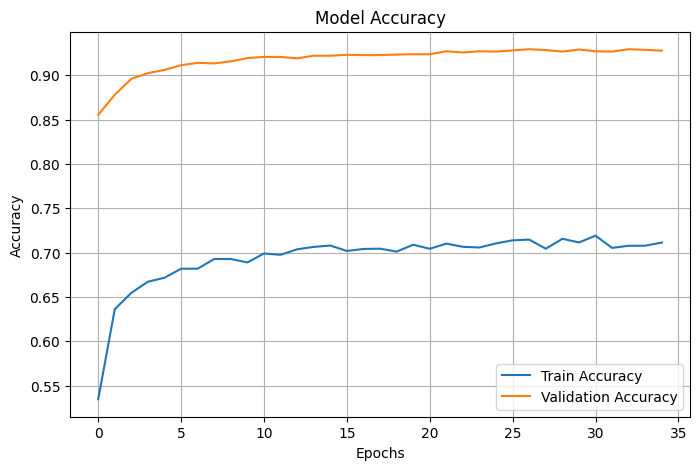

In [7]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.grid()
    plt.show(block=True)

plot_accuracy(history)

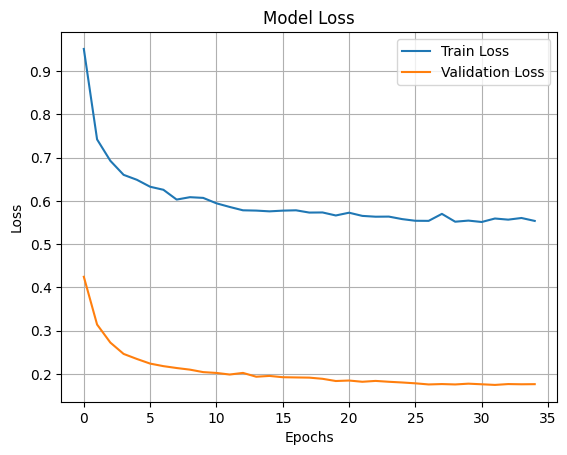

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

In [9]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.8953 - loss: 0.2436

🔹 Test Accuracy after initial training: 92.67%


In [19]:
import pickle
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

model = tf.keras.models.load_model('third_model_da.h5')

early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore weights from the best epoch
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce by half
    patience=2,  # Wait 2 epochs before reducing
    min_lr=1e-6,  # Don't go below this LR
    verbose=1
)

for layer in model.layers:
    if 'block5' in layer.name:
        layer.trainable = True
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False  # Optional: Freeze BatchNorm layers

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [20]:
epochs = 30
history_ft = model.fit(
    training_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

model.save("model3_ft.h5")
with open("history3_finetuned.pkl", "wb") as f:
    pickle.dump(history_ft.history, f)

print("✅ Fine-tuning complete. Model and history saved.")

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 412ms/step - accuracy: 0.7318 - loss: 0.5194 - val_accuracy: 0.9443 - val_loss: 0.1490 - learning_rate: 1.0000e-05
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 394ms/step - accuracy: 0.7417 - loss: 0.4913 - val_accuracy: 0.9493 - val_loss: 0.1421 - learning_rate: 1.0000e-05
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 399ms/step - accuracy: 0.7501 - loss: 0.4740 - val_accuracy: 0.9567 - val_loss: 0.1143 - learning_rate: 1.0000e-05
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 187s 398ms/step - accuracy: 0.7546 - loss: 0.4604 - val_accuracy: 0.9580 - val_loss: 0.1130 - learning_rate: 1.0000e-05
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 393ms/step - accuracy: 0.7598 - loss: 0.4431 - val_accuracy: 0.9637 - val_loss: 0.0934 - learning_rate: 1.0000e-05
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 179s 382ms/step - accuracy: 0.7623 - loss: 0.4403 - val_accuracy: 0.9630 - val_loss: 0.0916 - learning_rate: 1.0000e-05
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 

NameError: name 'history_finetune' is not defined

In [21]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"\n🔹 Test Accuracy after initial training: {test_accuracy * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - accuracy: 0.9577 - loss: 0.1282

🔹 Test Accuracy after initial training: 97.23%


In [2]:
from keras.api.models import load_model
from keras_preprocessing import image
import numpy as np

model = load_model('model3_ft.h5')

# Load and Predict a Single Image
test_image = image.load_img('/workspace/sdp/test/img_2.png', target_size=(150, 150))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0

result = model.predict(test_image)
class_index = np.argmax(result[0])
class_labels = {0: 'cat', 1: 'dog', 2: 'human'}
prediction = class_labels[class_index]

print(f"\n🟢 Prediction: {prediction}")

I0000 00:00:1744177479.995535    3689 service.cc:148] XLA service 0x7fef58005800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744177479.995832    3689 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-09 05:44:40.007776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744177480.083252    3689 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

🟢 Prediction: cat


I0000 00:00:1744177482.834037    3689 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
from keras.api.models import load_model
from keras_preprocessing.image import ImageDataGenerator

loaded_model = load_model('model3_ft.h5')

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

test_generator = test_datagen.flow_from_directory(
    r"/sdp/redd/test",
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
loss, accuracy = loaded_model.evaluate(test_generator)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Loss: {loss:.4f}")

import numpy as np
from sklearn.metrics import classification_report

y_true = test_generator.classes

y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

Found 3000 images belonging to 3 classes.


D:\sdp\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9577 - loss: 0.1282
Accuracy: 97.23%
Loss: 0.0774
94/94 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step
              precision    recall  f1-score   support

         cat       0.97      0.95      0.96      1000
         dog       0.95      0.97      0.96      1000
       human       1.00      1.00      1.00      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



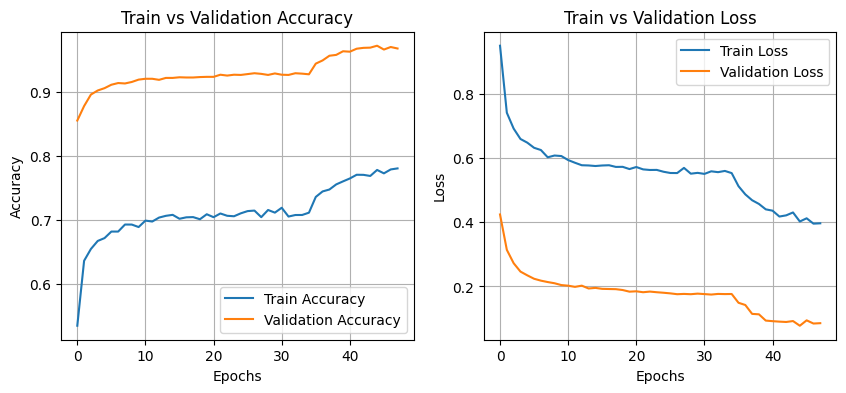

In [4]:
import pickle
import matplotlib.pyplot as plt

# Load histories
with open("history3_da.pkl", "rb") as f:
    history = pickle.load(f)

with open("history3_finetuned.pkl", "rb") as f:
    history_fine = pickle.load(f)


# Function to compare training and fine-tuning performance
def plot_fine_tuning(history, history_fine):
    # Access history dictionaries directly
    acc = history['accuracy'] + history_fine['accuracy']
    val_acc = history['val_accuracy'] + history_fine['val_accuracy']
    loss = history['loss'] + history_fine['loss']
    val_loss = history['val_loss'] + history_fine['val_loss']

    epochs_range = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid()

    plt.show()


# Call the function
plot_fine_tuning(history, history_fine)


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import ImageFile
from keras_preprocessing import image

ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn = tf.keras.models.load_model('model3_ft.h5')

cap = cv2.VideoCapture(0)
cap.set(3, 640)  # Width
cap.set(4, 480)  # Height

while True:
    ret, frame = cap.read()


    cv2.imshow('Camera', frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('c'):
        # Process the captured image
        test_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        test_image_resized = cv2.resize(test_image, (150, 150))
        test_image_resized = image.img_to_array(test_image_resized)
        test_image_resized = np.expand_dims(test_image_resized, axis=0)
        test_image_resized = test_image_resized / 255.0

        result = cnn.predict(test_image_resized)
        class_index = np.argmax(result[0])
        class_labels = {0: 'cat', 1: 'dog', 2: 'human'}

        prediction = class_labels[class_index]
        print(f"Prediction: {prediction}")

        h, w, _ = frame.shape
        top_left = (50, 50)
        bottom_right = (w - 50, h - 50)

        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        label_position = (top_left[0], top_left[1] - 10)
        cv2.putText(frame, prediction, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow('Camera with Bounding Box', frame)

    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediction: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Prediction: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s